<a href="https://colab.research.google.com/github/EleaReggiani/DeepLearning/blob/main/breed_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CNN DOGS BREED RECOGNITION**

 **IMPORT THE LIBRAIRIES**

In [ ]:
# files loading
import os
from random import shuffle
import numpy as np
from tqdm import tqdm 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pretreatment
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [ ]:
# libraries for a CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential,BatchNormalization,AveragePooling2D,MaxPooling2D,Conv2D,Activation,Dropout,Flatten,Input,Dense
import timeit
from numpy import expand_dims
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras import backend as K

 **GPU FOR BETTER SPEED DURING CNN COMPILING AND RUNNING**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#**LITTLE EDA**

In [ ]:
ANNOTATION_DIR = '/content/drive/MyDrive/Deeplearniing/Annotation' 
IMAGES_DIR = '/content/drive/MyDrive/Deeplearniing/Images'

In [ ]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [ ]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:20]

['miniature_poodle',
 'dingo',
 'toy_poodle',
 'standard_poodle',
 'Cardigan',
 'Brabancon_griffon',
 'Pembroke',
 'dhole',
 'Mexican_hairless',
 'African_hunting_dog',
 'chow',
 'Samoyed',
 'basenji',
 'pug',
 'Great_Pyrenees',
 'Leonberg',
 'keeshond',
 'Newfoundland',
 'Pomeranian',
 'affenpinscher']

n02111889-Samoyed


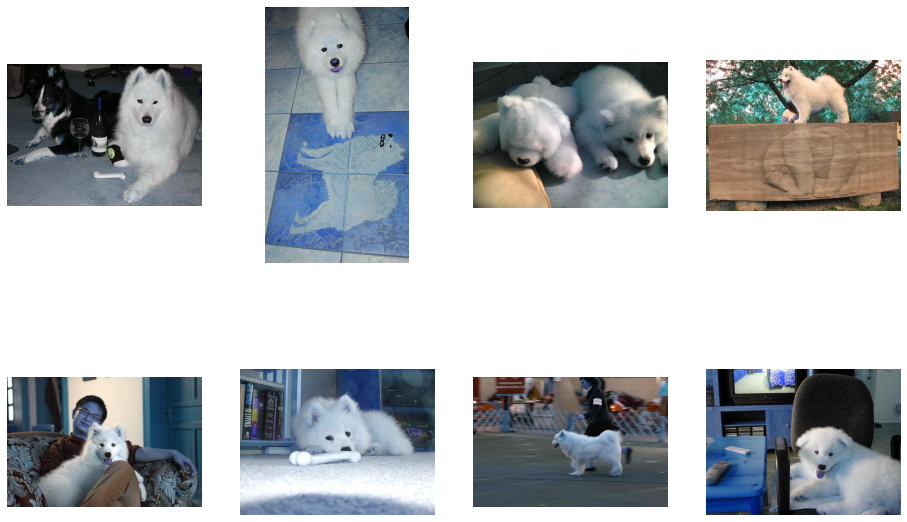

In [ ]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/content/drive/MyDrive/Deeplearniing/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[11])
show_dir_images(breed_list[11], 8)

# **PREPROOCESSING ON 20 BREEDS**

**IMAGES EQUALIZATION FOR BETTER ACCURACY**

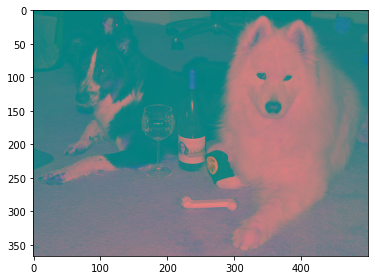

In [ ]:
img_dir = "/content/drive/MyDrive/Deeplearniing/Images/{}/".format(breed_list[11])
images = os.listdir(img_dir)[:12]
images = os.listdir(img_dir)[:4]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)

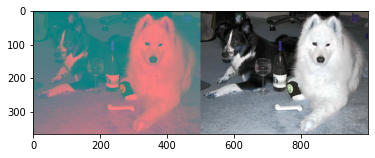

In [ ]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

Augmented by rotation:


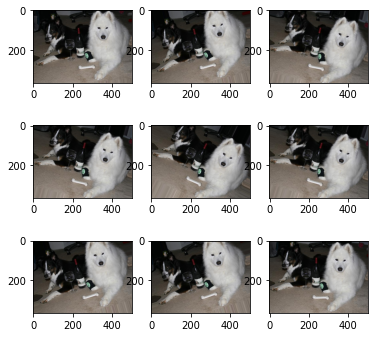

<Figure size 720x720 with 0 Axes>

In [ ]:
print("Augmented by rotation:")

# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

**PROCESSING FOR 20 BREEDS**

In [ ]:
num_breeds = 20 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # convert to yuv color space for equalization
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) 
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) 
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 224 x 224 because the input image resolution for VGG16 is 224 x 224
            resized_img = img_array.resize((224, 224))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  3552 
No. of labels loaded =  3552
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (3552, 224, 224, 3) 
Labels shape =  (3552,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


**SHUFFLING**

In [ ]:
#step 1 - get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("10 'n' values before shuffling = ",n[:10])

#shuffle all the equally spaced values in list 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 'n' values after shuffling = ",n[:10])

10 'n' values before shuffling =  [0 1 2 3 4 5 6 7 8 9]
10 'n' values after shuffling =  [ 299 1017 2071  752 1213  874 1320  912 1565 3208]


In [ ]:
#step 2 - shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)
print('same shapes before and after shuffling')

Images shape after shuffling =  (3552, 224, 224, 3) 
Labels shape after shuffling =  (3552,)
same shapes before and after shuffling


In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

**TRAIN, TEST, VALIDATION DATA**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (2556, 224, 224, 3)
y_train shape =  (2556,)

x_val shape =  (285, 224, 224, 3)
y_val shape =  (285,)

x_test shape =  (711, 224, 224, 3)
y_test shape =  (711,)


**CONSTRUCTING CNN FROM SCRATCH**

In [ ]:
model = Sequential()
# layer 1
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(224, 224, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(20, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_380 (Conv2D)          (None, 224, 224, 16)      432       
_________________________________________________________________
batch_normalization_380 (Bat (None, 224, 224, 16)      48        
_________________________________________________________________
activation_380 (Activation)  (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_381 (Conv2D)          (None, 56, 56, 32)        4608      
_________________________________________________________________
batch_normalization_381 (Bat (None, 56, 56, 32)       

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0015)

In [ ]:
%%time
history =model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=33)

Epoch 1/33
80/80 [==============================] - 3s 26ms/step - loss: 3.3090 - accuracy: 0.0793 - val_loss: 3.0947 - val_accuracy: 0.0491
Epoch 2/33
80/80 [==============================] - 2s 24ms/step - loss: 2.5980 - accuracy: 0.2033 - val_loss: 3.2667 - val_accuracy: 0.0526
Epoch 3/33
80/80 [==============================] - 2s 23ms/step - loss: 2.3852 - accuracy: 0.2595 - val_loss: 3.5430 - val_accuracy: 0.0456
Epoch 4/33
80/80 [==============================] - 2s 23ms/step - loss: 2.3038 - accuracy: 0.2804 - val_loss: 3.0253 - val_accuracy: 0.1509
Epoch 5/33
80/80 [==============================] - 2s 23ms/step - loss: 2.1378 - accuracy: 0.3293 - val_loss: 2.5177 - val_accuracy: 0.2140
Epoch 6/33
80/80 [==============================] - 2s 23ms/step - loss: 2.1022 - accuracy: 0.3314 - val_loss: 2.5354 - val_accuracy: 0.2140
Epoch 7/33
80/80 [==============================] - 2s 23ms/step - loss: 1.9413 - accuracy: 0.3768 - val_loss: 2.4081 - val_accuracy: 0.2316
Epoch 8/33
80

**ACCURACY**

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print(loss,accuracy)

23/23 [==============================] - 0s 12ms/step - loss: 3.3894 - accuracy: 0.3319
3.3893685340881348 0.3319268524646759


**LEARNING CURVES**

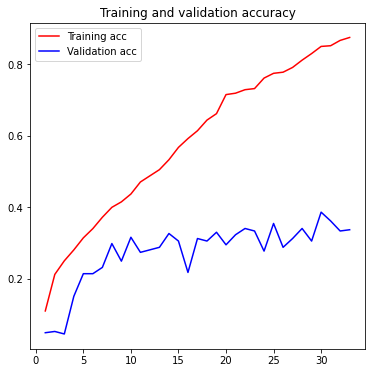

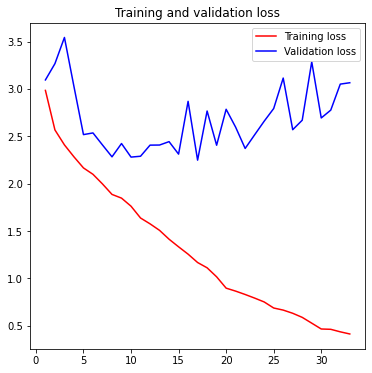

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**PREDICTION WITH TEST**

In [ ]:
pred = model.predict(x_test)

pred.shape

(711, 20)

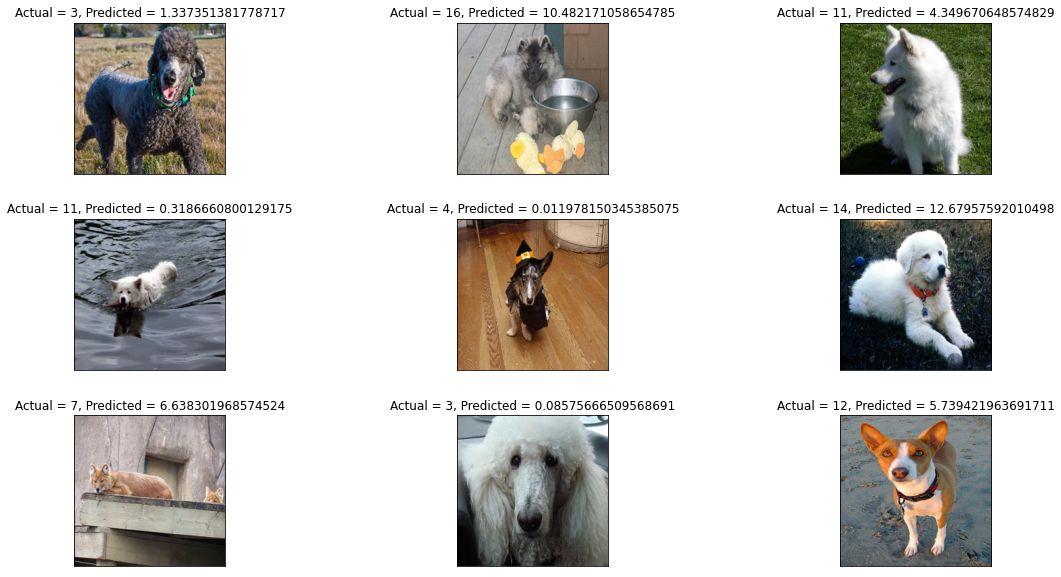

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

# **TRASNFER LEARNING WITH VGG16**

In [ ]:

from keras.applications.vgg16 import VGG16
modelVGG16 = VGG16(input_tensor=Input(shape=(224, 224, 3)))
custom_transfert_learning = Sequential()
for layer in modelVGG16.layers[:-1]:
  custom_transfert_learning.add(layer)
  custom_transfert_learning.summary()

for layer in custom_transfert_learning.layers:
  layer.trainable = False

custom_transfert_learning.add(Dense(units=20, activation='softmax'))

custom_transfert_learning.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
Total params: 

In [ ]:
modelVGG16.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(modelVGG16.optimizer.learning_rate, 0.0015)

In [ ]:
historyVGG16 =modelVGG16.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=17)

Epoch 1/17
80/80 [==============================] - 7s 80ms/step - loss: 3.7114 - accuracy: 0.1139 - val_loss: 2.4769 - val_accuracy: 0.2456
Epoch 2/17
80/80 [==============================] - 6s 77ms/step - loss: 2.3715 - accuracy: 0.2906 - val_loss: 2.1963 - val_accuracy: 0.3368
Epoch 3/17
80/80 [==============================] - 6s 78ms/step - loss: 2.0909 - accuracy: 0.3528 - val_loss: 2.0432 - val_accuracy: 0.3404
Epoch 4/17
80/80 [==============================] - 6s 77ms/step - loss: 1.9180 - accuracy: 0.3956 - val_loss: 2.2180 - val_accuracy: 0.3649
Epoch 5/17
80/80 [==============================] - 6s 77ms/step - loss: 1.9392 - accuracy: 0.4170 - val_loss: 1.9486 - val_accuracy: 0.3825
Epoch 6/17
80/80 [==============================] - 6s 77ms/step - loss: 1.8230 - accuracy: 0.4504 - val_loss: 1.8347 - val_accuracy: 0.4526
Epoch 7/17
80/80 [==============================] - 6s 77ms/step - loss: 1.7442 - accuracy: 0.4575 - val_loss: 1.7482 - val_accuracy: 0.4491
Epoch 8/17
80

**ACCURACY :**

In [ ]:
loss, accuracy = modelVGG16.evaluate(x_test, y_test)

print(loss,accuracy)

23/23 [==============================] - 2s 69ms/step - loss: 1.8209 - accuracy: 0.4219
1.8209192752838135 0.4219409227371216


**LEARNING CURVES**

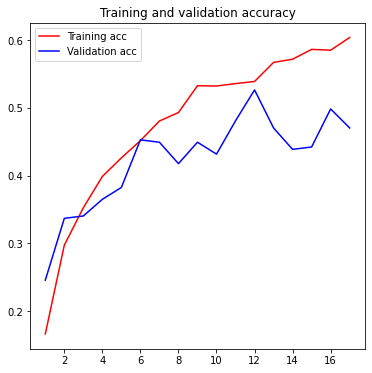

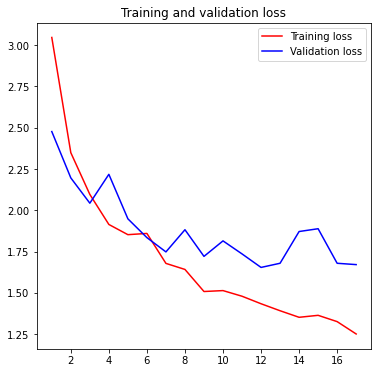

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = historyVGG16.history['accuracy']
val_acc = historyVGG16.history['val_accuracy']
loss = historyVGG16.history['loss']
val_loss = historyVGG16.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**PREDICTION**

In [ ]:
pred = modelVGG16.predict(x_test)

pred.shape

(711, 1000)

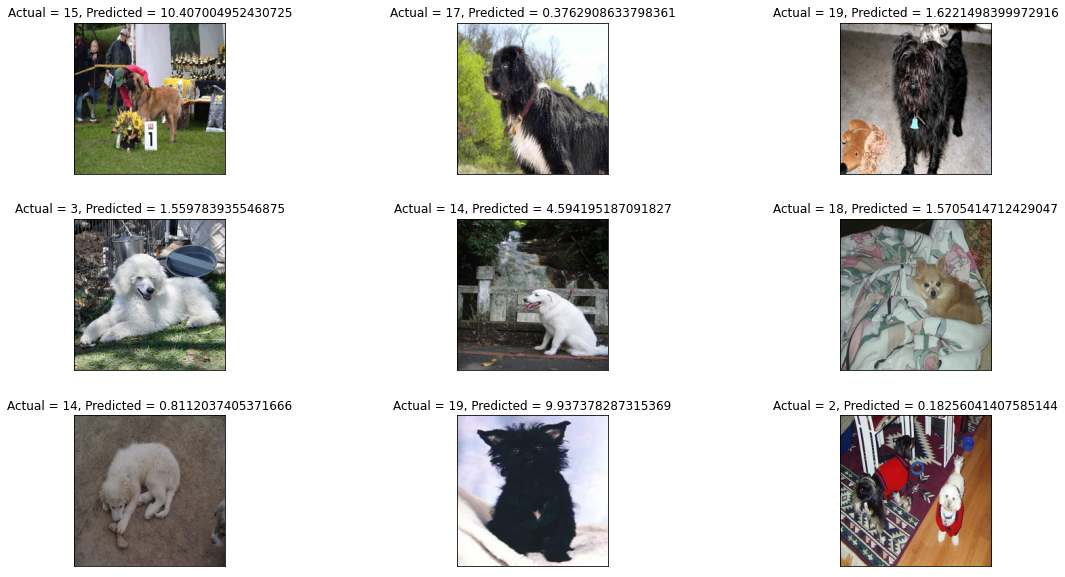

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

# **TRANSFER LEANRNIN WITH INCEPTIONV3**

In [ ]:
from tensorflow.keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D

InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (224, 224, 3), weights= 'imagenet')

model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False

model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))

# Ajout de la dernière couche avec num_classes (trainable=true)
model.add(Dense(20,activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                40980     
Total params: 21,843,764
Trainable params: 40,980
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0015)

In [ ]:
historyV3 =model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=17)

Epoch 1/17
80/80 [==============================] - 9s 71ms/step - loss: 1.3505 - accuracy: 0.6303 - val_loss: 0.3126 - val_accuracy: 0.9053
Epoch 2/17
80/80 [==============================] - 5s 58ms/step - loss: 0.2473 - accuracy: 0.9081 - val_loss: 0.3169 - val_accuracy: 0.9088
Epoch 3/17
80/80 [==============================] - 5s 58ms/step - loss: 0.1576 - accuracy: 0.9478 - val_loss: 0.3622 - val_accuracy: 0.8912
Epoch 4/17
80/80 [==============================] - 5s 58ms/step - loss: 0.1355 - accuracy: 0.9433 - val_loss: 0.3391 - val_accuracy: 0.9053
Epoch 5/17
80/80 [==============================] - 5s 57ms/step - loss: 0.0891 - accuracy: 0.9634 - val_loss: 0.3225 - val_accuracy: 0.9018
Epoch 6/17
80/80 [==============================] - 5s 58ms/step - loss: 0.1030 - accuracy: 0.9636 - val_loss: 0.3508 - val_accuracy: 0.8982
Epoch 7/17
80/80 [==============================] - 5s 57ms/step - loss: 0.0663 - accuracy: 0.9762 - val_loss: 0.3643 - val_accuracy: 0.8912
Epoch 8/17
80

**ACCURACY**

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print(loss,accuracy)

23/23 [==============================] - 1s 50ms/step - loss: 0.3464 - accuracy: 0.9058
0.3463612198829651 0.9057665467262268


**PREDICTION**

In [ ]:
pred = model.predict(x_test)

pred.shape

(711, 20)

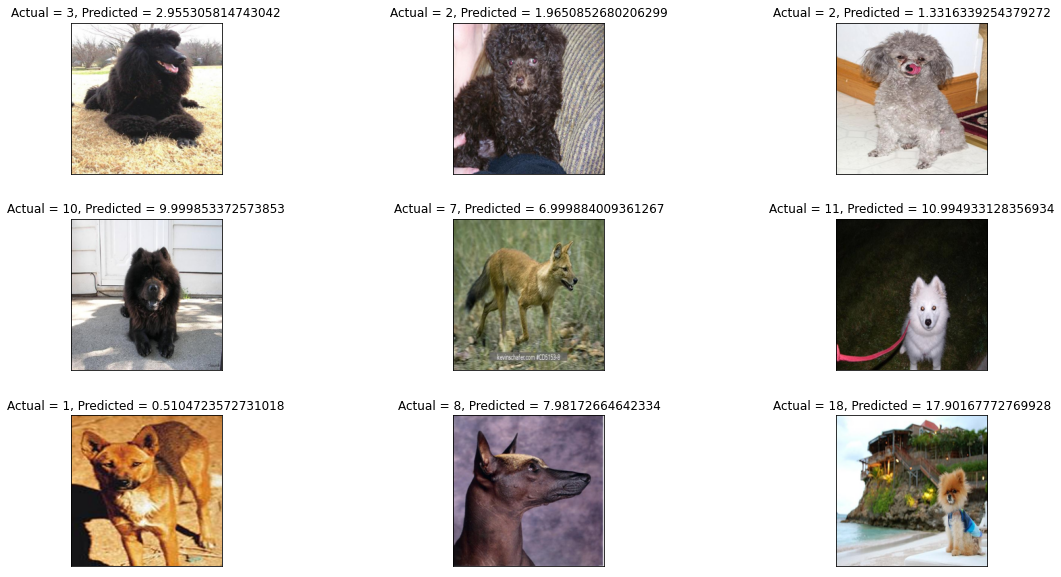

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

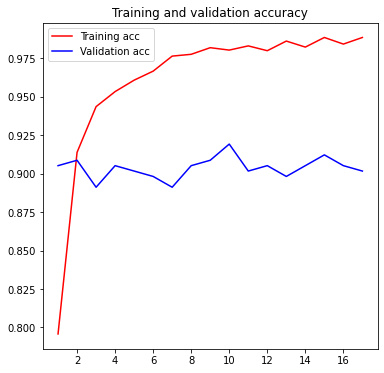

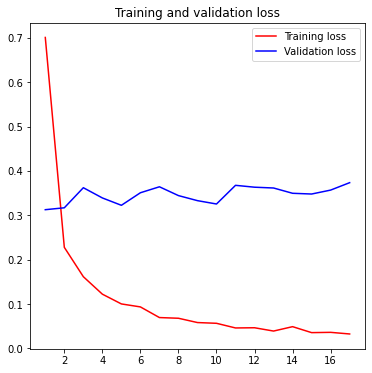

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = historyV3.history['accuracy']
val_acc = historyV3.history['val_accuracy']
loss = historyV3.history['loss']
val_loss = historyV3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()